In [2]:
library(tidyverse)
ggplot2::theme_set(theme_bw())

library(showtext)
font_add("nanum", "NanumGothic.ttf")
showtext_auto()

setwd("C:/Soongsil/R/Textmining")

In [3]:
font_add_google(name = "Black Han Sans", family = "blackhansans")
showtext_auto()

### 06-01 토픽 모델링
- document : 문서
- term : 단어

**문서1** : **고양이**가 **냐옹** 하고 **운다**.

**문서2** : **참치 김밥**을 **먹었다**

**문서3** : **털뭉치 고양이**가 **냐옹** 하더니 **참치**를 **먹었다**

| **단어** | **토픽 A** | **토픽 B** |
| -- | -- | -- |
| 털뭉치 | 16% | 0% |
| 고양이 | 33% | 0% |
| 냐옹 | 33% | 0% | 
| 운다 | 16%| 0% |
| 참치 | 0% | 40% |
| 김밥 | 0% | 20% |
| 먹었다 | 0% | 40% |

| | **토픽 A** | **토픽 B** |
| -- | -- | -- |
| 문서1 | 100% | 0% |
| 문서2 | 0% | 100% |
| 문서3 | 60% | 40% |

### LDA 모델 (Latent Dirichlet Allocation, 잠재 디리클레 할당)
- 토픽은 여러 단어의 혼합으로 구성

| **단어** | **고양이** | **음식** |
|-- | -- | -- |
| 털 | 45% | 0% |
| 모래 | 35% | 0% |
| 참치 | 20% | 5% | 
| 김밥 | 0% | 55% |
| 떡볶이 | 0% | 40% |

#### - 한 토픽에 여러 단어가 서로 다른 확률로 포함 
(참치는 다른 토픽에도 등장하므로 '털', '모래'에 비해 등장 확률이 낮음)
#### - 같은 단어가 여러 토픽에 서로 다른 확률로 포함
#### - 문서는 여러 토픽의 혼합으로 구성

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/

### 06-02 LDA 모델 만들기

In [4]:
raw_news_comment <- read_csv("news_comment_parasite.csv") %>%
  mutate(id = row_number())
raw_news_comment %>% print

Rows: 4150 Columns: 5
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (4): reply, press, title, url
dttm (1): reg_time

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4,150 x 6
   reg_time            reply                             press title url      id
   <dttm>              <chr>                             <chr> <chr> <chr> <int>
 1 2020-02-10 16:59:02 "정말 우리 집에 좋은 일이 생겨 ~  MBC   '기~  http~     1
 2 2020-02-10 13:32:24 "와 너무 기쁘다! 이 시국에 정말 ~ SBS   [영~  http~     2
 3 2020-02-10 12:30:09 "우리나라의 영화감독분들 그리고 ~ 한겨~ ‘기~  http~     3
 4 2020-02-10 13:08:22 "봉준호 감독과 우리나라 대한민국~ 한겨~ ‘기~  http~     4
 5 2020-02-10 16:25:41 "노벨상 탄느낌이네요\n축하축하 ~  한겨~ ‘기~  http~     5
 6 2020-02-10 12:31:45 "기생충 상 받을때 박수 쳤어요.감~ 한겨~ ‘기~  http~     6
 7 2020-02-10 12:31:33 "대한민국 영화사를 새로 쓰고 계~  한겨~ ‘기~  http~     7
 8 2020-02-11 09:20:52 "저런게 아카데미상 받으면  '태극~ 한겨~ ‘기~  http~     8
 9 2020-02-10 20:53:27 "다시한번 보여주세요 영화관에서 ~ 한겨~ ‘기~  http~     9
10 2020-02-10 20:22:41 "대한민국 BTS와함께  봉준호감독~  한겨~ ‘기~  http~    10
# ... with 4,140 more rows


### ```distinct()```
- ```.keep_all = T``` : 다른 변수들 모두 보유```

In [5]:
# 기본적인 전처리
news_comment <- raw_news_comment %>%
  mutate(reply = str_replace_all(reply, "[^가-힣]", " "),
         reply = str_squish(reply)) %>%

  # 중복 댓글 제거
  distinct(reply, .keep_all = T) %>%

  # 짧은 문서 제거 - 3 단어 이상 추출
  filter(str_count(reply, boundary("word")) >= 3)

In [6]:
library(tidytext)
library(KoNLP)

Checking user defined dictionary!




In [7]:
# 명사 추출
comment <- news_comment %>%
  unnest_tokens(input = reply,
                output = word,
                token = extractNoun,
                drop = F) %>%
  filter(str_count(word) > 1) %>%

  # 댓글 내 중복 단어 제거
  group_by(id) %>%
  distinct(word, .keep_all = T) %>%
  ungroup() %>%
  select(id, word)

comment %>% print

# A tibble: 21,457 x 2
      id word    
   <int> <chr>   
 1     1 우리    
 2     1 행복    
 3     2 시국    
 4     2 감사    
 5     2 하다    
 6     2 진심    
 7     3 우리나라
 8     3 영화감독
 9     3 영감    
10     3 봉감    
# ... with 21,447 more rows


In [11]:
count_word <- comment %>%
  add_count(word) %>%
  filter(n <= 200) %>%
  select(-n)

count_word %>% print

# A tibble: 18,210 x 2
      id word      
   <int> <chr>     
 1     1 우리      
 2     1 행복      
 3     2 시국      
 4     2 감사      
 5     2 하다      
 6     2 진심      
 7     3 우리나라  
 8     3 영화감독  
 9     3 영감      
10     3 공동각본쓴
# ... with 18,200 more rows


### 불용어, 유의어 확인

In [12]:
count_word %>%
  count(word, sort = T) %>%
  print

# A tibble: 6,022 x 2
   word           n
   <chr>      <int>
 1 작품상       200
 2 자랑         193
 3 블랙리스트   173
 4 조국         170
 5 한국         165
 6 대박         148
 7 세계         140
 8 수상         135
 9 미국         128
10 들이         123
# ... with 6,012 more rows


### 불용어 목록 (불용어 목록을 파일로 저장)

In [13]:
stopword <- tibble(word = c("들이", "하다", "하게", "하면", "해서", "이번", "하네",
              "해요", "이것", "니들", "하기", "하지", "한거", "해주",
              "그것", "어디", "여기", "까지", "이거", "하신", "만큼"))

write_csv(stopword, "stopword.csv")

stopword <- read_csv("stopword.csv")

Rows: 21 Columns: 1
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (1): word

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 불용어, 유의어 처리

### ```recode()``` : 특정 값을 다른 값으로 수정

In [14]:
count_word <- count_word %>%
  filter(!word %in% stopword) %>%
  mutate(word = recode(word,
                       "자랑스럽습니" = "자랑",
                       "자랑스럽" = "자랑",
                       "자한" = "자유한국당",
                       "문재" = "문재인",
                       "한국의" = "한국",
                       "그네" = "박근혜",
                       "추카" = "축하",
                       "정경" = "정경심",
                       "방탄" = "방탄소년단"))

### LDA 모델 생성
### 1. DTM (문서 단어 행렬) 생성
1.1 문서별 단어 빈도

In [15]:
count_word_doc <- count_word %>%
  count(id, word, sort = T)

count_word_doc %>% print

# A tibble: 18,198 x 3
      id word           n
   <int> <chr>      <int>
 1    35 한국           2
 2   206 자랑           2
 3   566 자랑           2
 4   578 자랑           2
 5   598 자랑           2
 6  1173 한국           2
 7  1599 한국           2
 8  1762 한국           2
 9  2240 한국           2
10  2307 방탄소년단     2
# ... with 18,188 more rows


1.2 DTM 생성

### ```tidytext::cast_dtm()``` : 단어 빈도를 DTM으로
- ```document``` : 문서 구분 기준
- ```term``` : 단어
- ```value``` : 단어 빈도

In [16]:
dtm_comment <- count_word_doc %>%
  cast_dtm(document = id, term = word, value = n)

dtm_comment

<<DocumentTermMatrix (documents: 3219, terms: 6016)>>
Non-/sparse entries: 18198/19347306
Sparsity           : 100%
Maximal term length: 35
Weighting          : term frequency (tf)

3203문서 X 5995 단어

In [19]:
library(tm)
as.matrix(dtm_comment[1:8, 1:8])

,한국,자랑,방탄소년단,박근혜,우리,행복,감사,시국
35,2,0,0,0,0,0,0,0
206,0,2,0,0,0,0,0,0
566,1,2,0,0,0,0,0,0
578,0,2,0,0,0,0,0,0
598,0,2,0,0,0,0,0,0
1173,2,0,0,0,0,0,0,0
1599,2,1,0,0,0,0,0,0
1762,2,0,0,0,0,0,0,0


### 2. LDA 모델 만들기
### ```LDA()```
- ```k``` : 토픽 수
- ```method``` : 샘플링 방법 (```"Gibbls"``` : 깁스 샘플링)
- ```control = list(seed = 1234)```

In [20]:
library(topicmodels)

In [21]:
lda_model <- LDA(dtm_comment,
                 k = 8,
                 method = "Gibbs",
                 control = list(seed = 1234))
lda_model

A LDA_Gibbs topic model with 8 topics.

In [22]:
glimpse(lda_model)

Formal class 'LDA_Gibbs' [package "topicmodels"] with 16 slots
  ..@ seedwords      : NULL
  ..@ z              : int [1:18210] 7 7 8 6 2 5 2 3 5 2 ...
  ..@ alpha          : num 6.25
  ..@ call           : language LDA(x = dtm_comment, k = 8, method = "Gibbs", control = list(seed = 1234))
  ..@ Dim            : int [1:2] 3219 6016
  ..@ control        :Formal class 'LDA_Gibbscontrol' [package "topicmodels"] with 14 slots
  ..@ k              : int 8
  ..@ terms          : chr [1:6016] "한국" "자랑" "방탄소년단" "박근혜" ...
  ..@ documents      : chr [1:3219] "35" "206" "566" "578" ...
  ..@ beta           : num [1:8, 1:6016] -7.86 -10.3 -3.84 -10.29 -7.84 ...
  ..@ gamma          : num [1:3219, 1:8] 0.0919 0.1318 0.1078 0.1318 0.1096 ...
  ..@ wordassignments:List of 5
  .. ..$ i   : int [1:18198] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ j   : int [1:18198] 1 105 106 107 108 109 110 111 112 113 ...
  .. ..$ v   : num [1:18198] 7 6 6 2 5 2 3 5 2 7 ...
  .. ..$ nrow: int 3219
  .. ..$ ncol: int 6016
  .. 

### - ```@beta``` : 단어가 각 토픽에 등장할 확률
### - ```@gamma``` : 문서가 각 토픽에 등장할 확률

### 06-03 토픽별 주요 단어 탐색

<br/>

**beta 추출**

### ```tidytext::tidy()``` 
- ```matrix = "beta"```

In [23]:
term_topic <- tidy(lda_model, matrix = "beta")
term_topic %>% print

# A tibble: 48,128 x 3
   topic term       beta
   <int> <chr>     <dbl>
 1     1 한국  0.000388 
 2     2 한국  0.0000336
 3     3 한국  0.0215   
 4     4 한국  0.0000340
 5     5 한국  0.000392 
 6     6 한국  0.0000351
 7     7 한국  0.0461   
 8     8 한국  0.0000351
 9     1 자랑  0.00109  
10     2 자랑  0.0000336
# ... with 48,118 more rows


**beta 살펴보기**
- 토픽별 단어 수

In [24]:
term_topic %>%
  count(topic) %>% print

# A tibble: 8 x 2
  topic     n
  <int> <int>
1     1  6016
2     2  6016
3     3  6016
4     4  6016
5     5  6016
6     6  6016
7     7  6016
8     8  6016


- 토픽 1의 beta 합계

In [25]:
term_topic %>%
  filter(topic == 1) %>%
  summarise(sum_beta = sum(beta))

sum_beta
<dbl>
1


**특정 단어의 토픽별 확률**

In [26]:
term_topic %>%
  filter(term == "작품상") %>% print

# A tibble: 8 x 3
  topic term        beta
  <int> <chr>      <dbl>
1     1 작품상 0.0000352
2     2 작품상 0.0000336
3     3 작품상 0.0000346
4     4 작품상 0.0000340
5     5 작품상 0.0674   
6     6 작품상 0.00389  
7     7 작품상 0.0000349
8     8 작품상 0.0000351


### 토픽별 주요 단어 탐색
**특정 토픽에서 beta가 높은 단어 탐색**

In [27]:
term_topic %>%
  filter(topic == 6) %>%
  arrange(-beta) %>% print

# A tibble: 6,016 x 3
   topic term      beta
   <int> <chr>    <dbl>
 1     6 대박   0.0302 
 2     6 역사   0.0249 
 3     6 작품   0.0218 
 4     6 미국   0.0214 
 5     6 오늘   0.0190 
 6     6 호감   0.0155 
 7     6 시상식 0.0144 
 8     6 소감   0.0130 
 9     6 국제   0.00881
10     6 정경심 0.00845
# ... with 6,006 more rows


**모든 토픽의 주요 단어 탐색**
### ```topicmodels::terms()``` : 토픽별로 등장 확률이 높은 단어 확인

In [28]:
terms(lda_model, 20) %>%
  data.frame()

Topic.1,Topic.2,Topic.3,Topic.4,Topic.5,Topic.6,Topic.7,Topic.8
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
수상,블랙리스트,진심,조국,작품상,대박,자랑,세계
들이,박근혜,정치,하다,감독상,역사,한국,문화
좌파,문재인,한국,최고,대박,작품,오스카,우리나라
미국,송강호,한국인,배우,국민,미국,세계,수상소감
빨갱이,정권,순간,한국영화,각본상,오늘,감격,하게
하면,사람,보수,나라,소름,호감,우리,우리
얘기,자유한국당,하나,인정,아카데미상,시상식,경사,감사
와우,이미경,호가,가족,기사,소감,눈물,정치
니들,정부,이번,우리나라,로컬,국제,쾌거,외국


### 토픽별 주요 단어 시각화
**토픽별로 beta가 가장 높은 단어 추출**

In [29]:
# 토픽별 beta 상위 10개 단어 추출
top_term_topic <- term_topic %>%
  group_by(topic) %>%
  slice_max(beta, n = 10)

top_term_topic %>% print

# A tibble: 81 x 3
# Groups:   topic [8]
   topic term      beta
   <int> <chr>    <dbl>
 1     1 수상   0.0423 
 2     1 들이   0.0335 
 3     1 좌파   0.0261 
 4     1 미국   0.0226 
 5     1 빨갱이 0.0145 
 6     1 하면   0.0106 
 7     1 얘기   0.00849
 8     1 와우   0.00779
 9     1 니들   0.00779
10     1 호감   0.00673
# ... with 71 more rows


In [31]:
library(scales)

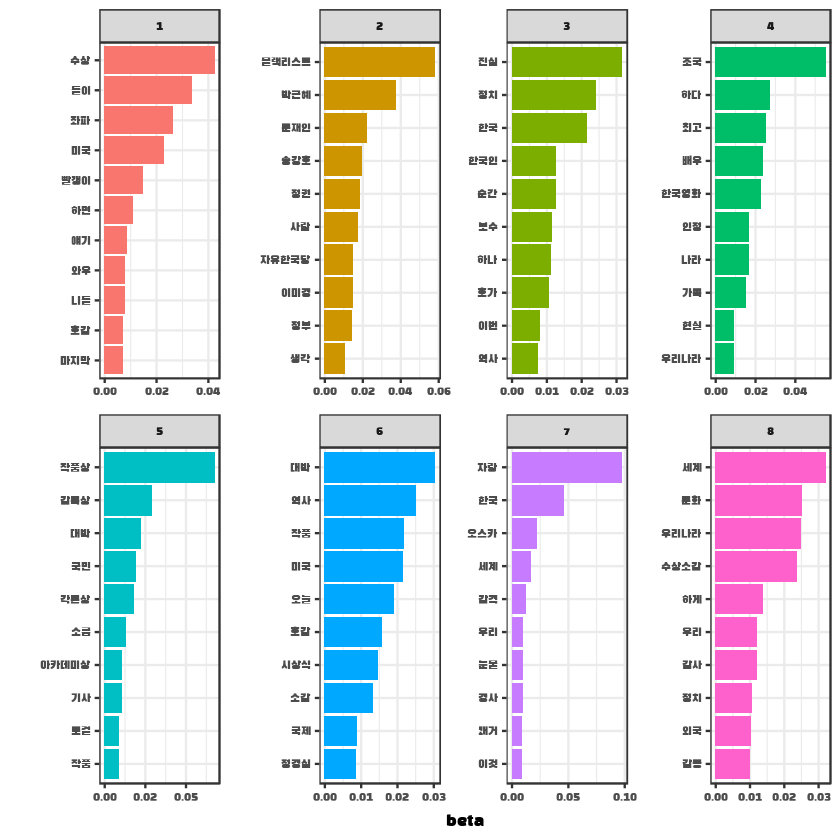

In [32]:
ggplot(top_term_topic,
       aes(x = reorder_within(term, beta, topic),
           y = beta,
           fill = factor(topic))) +
  geom_col(show.legend = F) +
  facet_wrap(~ topic, scales = "free", ncol = 4) +
  coord_flip() +
  scale_x_reordered() +
  scale_y_continuous(n.breaks = 4,
                     labels = number_format(accuracy = .01)) + 
  labs(x = NULL) +
  theme(text = element_text(family = "blackhansans"))

### 06-04 문서를 토픽별로 분류

<br/>

**gamma 추출**

In [33]:
doc_topic <- tidy(lda_model, matrix = "gamma")
doc_topic %>% print

# A tibble: 25,752 x 3
   document topic  gamma
   <chr>    <int>  <dbl>
 1 35           1 0.0919
 2 206          1 0.132 
 3 566          1 0.108 
 4 578          1 0.132 
 5 598          1 0.110 
 6 1173         1 0.125 
 7 1599         1 0.112 
 8 1762         1 0.0962
 9 2240         1 0.108 
10 2307         1 0.102 
# ... with 25,742 more rows


In [34]:
doc_topic %>%
  count(topic) %>% print

# A tibble: 8 x 2
  topic     n
  <int> <int>
1     1  3219
2     2  3219
3     3  3219
4     4  3219
5     5  3219
6     6  3219
7     7  3219
8     8  3219


In [35]:
# 문서 1의 gamma 합계
doc_topic %>%
  filter(document == 1) %>%
  summarise(sum_gamma = sum(gamma))

sum_gamma
<dbl>
1


### 문서를 확률이 가장 높은 토픽으로 분류
**문서별로 확률이 가장 높은 토픽 추출**

In [36]:
doc_class <- doc_topic %>%
  group_by(document) %>%
  slice_max(gamma, n = 1)

doc_class %>% print

# A tibble: 5,454 x 3
# Groups:   document [3,219]
   document topic gamma
   <chr>    <int> <dbl>
 1 1            8 0.159
 2 10           8 0.15 
 3 100          5 0.153
 4 1000         6 0.15 
 5 1001         1 0.15 
 6 1001         3 0.15 
 7 1002         2 0.137
 8 1002         6 0.137
 9 1002         7 0.137
10 1003         8 0.142
# ... with 5,444 more rows


**원문에 확률이 가장 높은 토픽 번호 부여**

In [37]:
doc_class$document <- as.integer(doc_class$document)

# 원문에 토픽 번호 부여
news_comment_topic <- raw_news_comment %>%
  left_join(doc_class, by = c("id" = "document"))

news_comment_topic %>%
  select(id, topic) %>% print

# A tibble: 6,385 x 2
      id topic
   <int> <int>
 1     1     8
 2     2     8
 3     3     3
 4     4     7
 5     5     3
 6     5     4
 7     6     5
 8     7    NA
 9     8     1
10     9     4
# ... with 6,375 more rows


**토픽별 문서 수 탐색**
- 각 토픽으로 문서가 몇 개씩 분류됬는지 확인

In [38]:
news_comment_topic %>%
  count(topic) %>% print

# A tibble: 9 x 2
  topic     n
  <int> <int>
1     1   633
2     2   656
3     3   676
4     4   720
5     5   717
6     6   663
7     7   737
8     8   652
9    NA   931


In [39]:
news_comment_topic <- news_comment_topic %>%
  na.omit() 

news_comment_topic %>% count(topic) %>% print

# A tibble: 8 x 2
  topic     n
  <int> <int>
1     1   633
2     2   656
3     3   676
4     4   720
5     5   717
6     6   663
7     7   737
8     8   652


### 문서를 한 토픽으로만 분류
### ```slice_sample()``` : 무작위 추출

In [40]:
set.seed(1234)
doc_class_unique <- doc_topic %>%
  group_by(document) %>%
  slice_max(gamma, n = 1) %>%
  slice_sample(n = 1)

doc_class_unique %>% count(document, sort = T) %>% print

# A tibble: 3,219 x 2
# Groups:   document [3,219]
   document     n
   <chr>    <int>
 1 1            1
 2 10           1
 3 100          1
 4 1000         1
 5 1001         1
 6 1002         1
 7 1003         1
 8 1004         1
 9 1005         1
10 1006         1
# ... with 3,209 more rows


### 토픽별 문서 수와 단어 시각화
**토픽별 주요 단어 목록**

In [41]:
top_terms <- term_topic %>%
  group_by(topic) %>%
  slice_max(beta, n = 6, with_ties = F) %>%
  summarise(term = paste(term, collapse = ", "))

top_terms %>% print

# A tibble: 8 x 2
  topic term                                          
  <int> <chr>                                         
1     1 수상, 들이, 좌파, 미국, 빨갱이, 하면          
2     2 블랙리스트, 박근혜, 문재인, 송강호, 정권, 사람
3     3 진심, 정치, 한국, 한국인, 순간, 보수          
4     4 조국, 하다, 최고, 배우, 한국영화, 나라        
5     5 작품상, 감독상, 대박, 국민, 각본상, 소름      
6     6 대박, 역사, 작품, 미국, 오늘, 호감            
7     7 자랑, 한국, 오스카, 세계, 감격, 우리          
8     8 세계, 문화, 우리나라, 수상소감, 하게, 우리    


**토픽별 문서 빈도**

In [42]:
count_topic <- news_comment_topic %>%
  count(topic)

count_topic %>% print

# A tibble: 8 x 2
  topic     n
  <int> <int>
1     1   633
2     2   656
3     3   676
4     4   720
5     5   717
6     6   663
7     7   737
8     8   652


**문서 빈도에 주요 단어 결합**

In [43]:
count_topic_word <- count_topic %>%
  left_join(top_terms, by = "topic") %>%
  mutate(topic_name = paste("Topic", topic))

count_topic_word %>% print

# A tibble: 8 x 4
  topic     n term                                           topic_name
  <int> <int> <chr>                                          <chr>     
1     1   633 수상, 들이, 좌파, 미국, 빨갱이, 하면           Topic 1   
2     2   656 블랙리스트, 박근혜, 문재인, 송강호, 정권, 사람 Topic 2   
3     3   676 진심, 정치, 한국, 한국인, 순간, 보수           Topic 3   
4     4   720 조국, 하다, 최고, 배우, 한국영화, 나라         Topic 4   
5     5   717 작품상, 감독상, 대박, 국민, 각본상, 소름       Topic 5   
6     6   663 대박, 역사, 작품, 미국, 오늘, 호감             Topic 6   
7     7   737 자랑, 한국, 오스카, 세계, 감격, 우리           Topic 7   
8     8   652 세계, 문화, 우리나라, 수상소감, 하게, 우리     Topic 8   


**그래프**

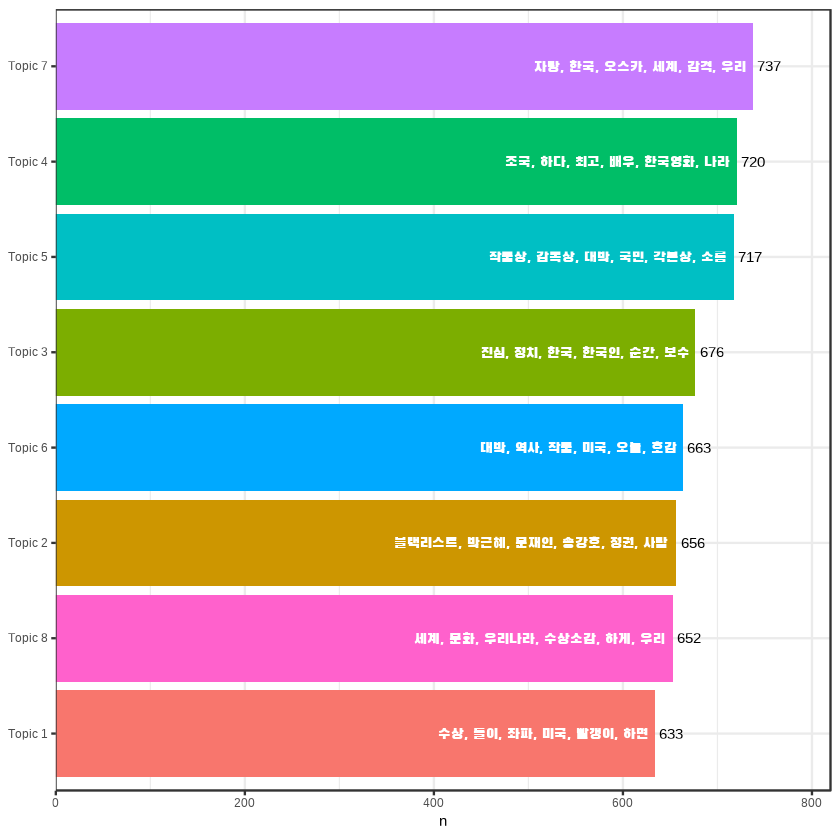

In [44]:
ggplot(count_topic_word,
       aes(x = reorder(topic_name, n),
           y = n,
           fill = topic_name)) +
  geom_col(show.legend = F) +
  coord_flip() +

  geom_text(aes(label = n) ,                # 문서 빈도 표시
            hjust = -0.2) +                 # 막대 밖에 표시

  geom_text(aes(label = term),              # 주요 단어 표시
            hjust = 1.03,                   # 막대 안에 표시
            col = "white",                  # 색깔
            fontface = "bold",              # 두껍게
            family = "blackhansans") +       # 폰트

  scale_y_continuous(expand = c(0, 0),      # y축-막대 간격 줄이기
                     limits = c(0, 820)) +  # y축 범위
  labs(x = NULL)

### 06-05 토픽 이름 짓기

### 토픽별 주요 문서 살펴보고 토픽 이름 작명
**원문을 읽기 편하게 전처리, gamma가 높은 순으로 정렬**

In [45]:
library(textclean)
comment_topic <- news_comment_topic %>%
  mutate(reply = str_squish(replace_html(reply))) %>%
  arrange(-gamma) 

comment_topic %>%
  select(gamma, reply) %>% print

# A tibble: 5,454 x 2
   gamma reply                                                                  
   <dbl> <chr>                                                                  
 1 0.241 2019년 헐리우드 매출 중국 50.3억불, 일본 8.6억불, 한국 10.3억불로 헐리~
 2 0.239 한편으론 봉준호감독이 아카데미시상식을 로컬영화제라고 말했던게 신의한~ 
 3 0.233 ‘실력파’로 알려진 중견 감독 ㄱ씨는 2013년말~2014년초 서울 강남의 한 ~  
 4 0.227 기생충 보면서 누가 기생충인가 봐더니 조여정이 박근혜역 이정은이가 짐사~
 5 0.225 봉준호 감독과 송강호 배우는 이명박그네 정권 시절 문화계 블랙리스트 였~ 
 6 0.223 이제 닭근혜 피해서 외국으로 피신한 CJ 사람들 다 귀국해라 고생들 많았다~
 7 0.221 이 말인즉, 작품성 예술성 심지어 대중성 까지 모두 잡았다는 얘기. 칸영화~
 8 0.220 기생충이 세계적인 영화제를 수상한건 매우 비정치적이고 현실세계를 제대~ 
 9 0.219 감빵 박근혜가 얼마나 대단하냐? 봉준호, 송강호 두 사람을 다 블랙리스트~ 
10 0.216 요즘 오스카는 대중성[어렵지 않고 재미가 있는] 없는 영화에 상을 안주는 ~
# ... with 5,444 more rows


**주요 단어가 사용된 문서 탐색**

In [46]:
comment_topic %>%
  filter(topic == 1 & str_detect(reply, "작품")) %>%
  head() %>%
  pull(reply) %>% print

[1] "이 말인즉, 작품성 예술성 심지어 대중성 까지 모두 잡았다는 얘기. 칸영화제와 미국아카데미 동시수상. 예술영화인척 겉멋부리지 않았고, 담백하고 웃음을 불러일으키는 대중성 속에 그 누구도 알지만 얘기하고싶지 않은 인간내면을 들춰준, 문학으로 따지면 노벨문학상 급의 영화다. 한국의 위상에 걸맞게 외국 나가면 행동 바르게 합시다. 안그래도 중국인이랑 똑같이 생겼다는 이유로 쓰레기 취급받는게 서러운데 우리라도 잘해야"                                                                                                              
[2] "요즘 오스카는 대중성[어렵지 않고 재미가 있는] 없는 영화에 상을 안주는 경향이 있다. 시상식의 화제성과 흥행 때문이겠지. 작년 수상작 그린북도 그랬고 기생충 역시 작품성과 대중성 모두 갖췄다는게 4관왕의 비결인듯."                                                                                                                                                                                                                                                                                                                  
[3] "1917이 못받은 이유좀? 기생충 작품상은 진짜 납득안되는데 1917,원어할,포드페라리,조커가 당연이었는데..."                                                                                                                                                        

**토픽 이름 목록 만들기**

In [47]:
name_topic <- tibble(topic = 1:8,
                     name = c("1. 작품상 수상 축하, 정치적 댓글 비판",
                              "2. 수상 축하, 시상식 감상",
                              "3. 조국 가족, 정치적 해석",
                              "4. 새 역사 쓴 세계적인 영화",
                              "5. 자랑스럽고 감사한 마음",
                              "6. 놀라운 4관왕 수상",
                              "7. 문화계 블랙리스트, 보수 정당 비판",
                              "8. 한국의 세계적 위상"))

### 토픽 이름과 주요 단어 시각화

In [48]:
# 토픽 이름 결합하기
top_term_topic_name <- top_term_topic %>%
  left_join(name_topic, name_topic, by = "topic")

top_term_topic_name %>% print

# A tibble: 81 x 4
# Groups:   topic [8]
   topic term      beta name                                 
   <int> <chr>    <dbl> <chr>                                
 1     1 수상   0.0423  1. 작품상 수상 축하, 정치적 댓글 비판
 2     1 들이   0.0335  1. 작품상 수상 축하, 정치적 댓글 비판
 3     1 좌파   0.0261  1. 작품상 수상 축하, 정치적 댓글 비판
 4     1 미국   0.0226  1. 작품상 수상 축하, 정치적 댓글 비판
 5     1 빨갱이 0.0145  1. 작품상 수상 축하, 정치적 댓글 비판
 6     1 하면   0.0106  1. 작품상 수상 축하, 정치적 댓글 비판
 7     1 얘기   0.00849 1. 작품상 수상 축하, 정치적 댓글 비판
 8     1 와우   0.00779 1. 작품상 수상 축하, 정치적 댓글 비판
 9     1 니들   0.00779 1. 작품상 수상 축하, 정치적 댓글 비판
10     1 호감   0.00673 1. 작품상 수상 축하, 정치적 댓글 비판
# ... with 71 more rows


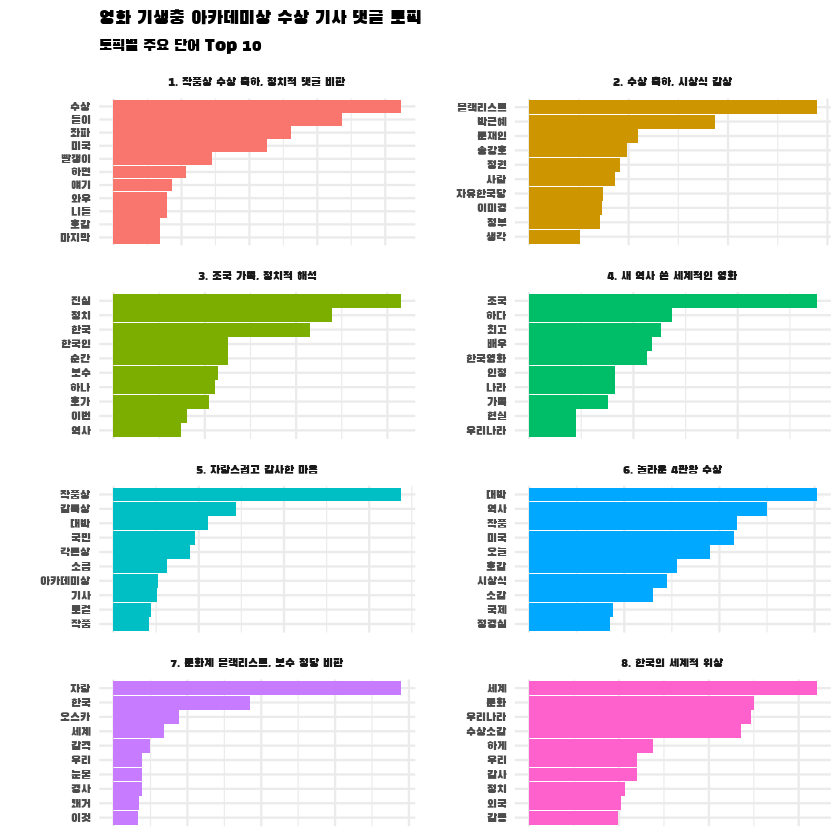

In [49]:
ggplot(top_term_topic_name,
       aes(x = reorder_within(term, beta, name),
           y = beta,
           fill = factor(topic))) +
  geom_col(show.legend = F) +
  facet_wrap(~ name, scales = "free", ncol = 2) +
  coord_flip() +
  scale_x_reordered() +

  labs(title = "영화 기생충 아카데미상 수상 기사 댓글 토픽",
       subtitle = "토픽별 주요 단어 Top 10",
       x = NULL, y = NULL) +

  theme_minimal() +
  theme(text = element_text(family = "blackhansans"),
        title = element_text(size = 12),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

### 06-06 최적의 토픽 수

### 방법1 : 모델의 내뇽을 보고 해석 가능성을 고려해 토픽 수 정하기
1. 주요 단어가 토픽을 잘 대표하는지
2. 문서가 비슷한 내용끼리 잘 분류되었는지
3. 모델이 텍스트를 해석하는데 도움이 되는지
- 시간이 많이 소요 (일일이 모델의 내용을 확인, 텍스트에 대한 사전 지식 필요)

### 방법2 : 여러 모델의 성능 지표를 비교해 토픽 수 정하기
- 토픽 수를 바꾸어 가며 여러 모델 생성, 모델이 텍스트를 설명하는 정도를 나타낸 성능 지표를 비교
- 하이퍼파라미터 튜닝
- 여러 모델을 만들어야함 (시간 소요)

### 방법3 : 두 가지 혼용
- 하이퍼파라미터 튜닝으로 몇 개의 후보 모델 선정 => 그 중에서 해석 가능성이 큰 모델을 최종적으로 선ㄴ택

### 토픽 수 바꿔가며 복수의 LDA모델 생성
### ```ldatuning::FindTopicsNumber()``` : 토픽 수를 바꾸어 가며 여러 모델 새성해 비교
- ```dtm``` : DTM
- ```topics``` : 비교할 최소-최대 토픽 수
- ```return_models``` : 모델 저장 여부
- ```control = list(seed = 1234)```
- ```metrics``` : 최소화 (Arun2010, CaoJuan2009) / 최대화 (Deveaud2014, Griffiths2004 [4,5])

https://cran.r-project.org/web/packages/ldatuning/vignettes/topics.html

In [50]:
library(ldatuning)

In [51]:
models <- FindTopicsNumber(dtm = dtm_comment,
                           topics = 2:20,
                           metrics = c("Griffiths2004", "CaoJuan2009", "Arun2010", "Deveaud2014"),
                           return_models = T,
                           control = list(seed = 1234))

models %>% 
    select(Griffiths2004, CaoJuan2009, Arun2010, Deveaud2014)

Griffiths2004,CaoJuan2009,Arun2010,Deveaud2014
<dbl>,<dbl>,<dbl>,<dbl>
-131157.9,0.08780369,1526.439,1.015496
-130740.5,0.09431641,1542.041,1.028721
-130611.8,0.08644132,1545.739,1.060564
-130687.0,0.08754427,1562.700,1.084440
-130456.7,0.07944710,1568.457,1.118326
-130936.7,0.07348053,1577.878,1.159919
-130435.9,0.07611393,1602.832,1.177746
-130446.2,0.08449359,1627.282,1.205505
-130399.6,0.06787643,1635.014,1.260404


### ```ldatuning::FindTopicsNumber_plot()```
- 토픽 수를 늘려도 성능이 크게 향상되지 않고 등락을 반복하기 시작하는 지점에서 토픽 수 선정

Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated."


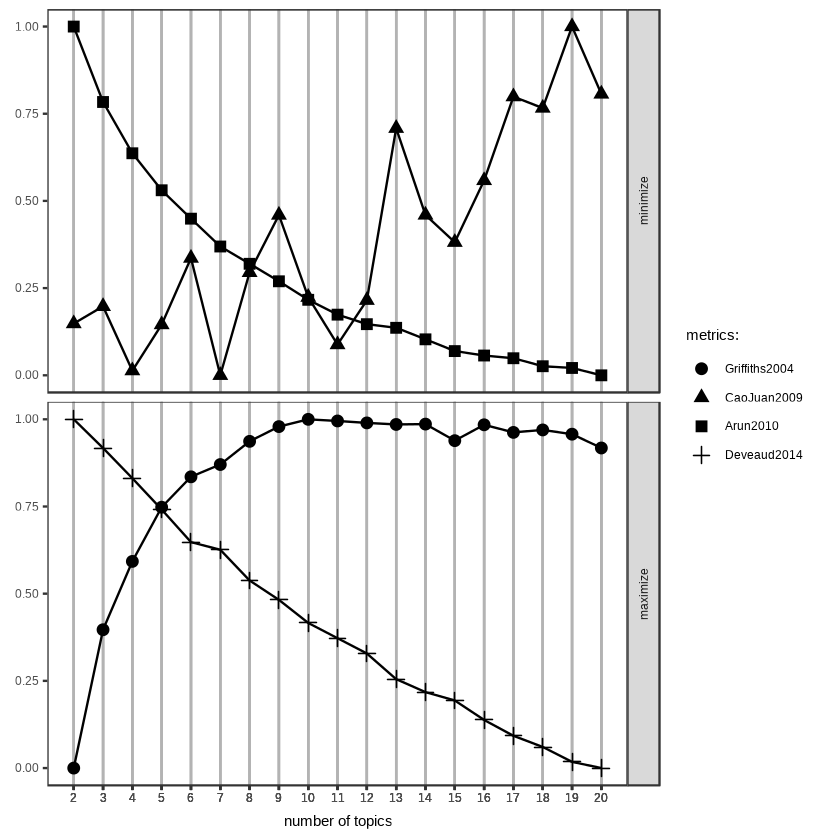

In [52]:
FindTopicsNumber_plot(models)

**모델 추출**

In [53]:
optimal_model <- models %>%
  filter(topics == 8) %>%
  pull(LDA_model) %>%              # 모델 추출
  .[[1]]                           # list 추출

In [54]:
# optimal_model
tidy(optimal_model, matrix = "beta") %>% print

# A tibble: 48,128 x 3
   topic term       beta
   <int> <chr>     <dbl>
 1     1 한국  0.000388 
 2     2 한국  0.0000336
 3     3 한국  0.0215   
 4     4 한국  0.0000340
 5     5 한국  0.000392 
 6     6 한국  0.0000351
 7     7 한국  0.0461   
 8     8 한국  0.0000351
 9     1 자랑  0.00109  
10     2 자랑  0.0000336
# ... with 48,118 more rows


### Q1

In [110]:
speeches_raw <- read_csv("speeches_roh.csv")

Rows: 780 Columns: 9
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (7): title, date, president, place, event, source, content
dbl (2): paragraph, id

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [111]:
speeches <- speeches_raw %>%
  unnest_tokens(input = content,
                output = sentence,
                token = "sentences",
                drop = F)

speeches %>% print

# A tibble: 39,714 x 10
   title     date  president place event source paragraph content    id sentence
   <chr>     <chr> <chr>     <chr> <chr> <chr>      <dbl> <chr>   <dbl> <chr>   
 1 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 2 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
 3 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
 4 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 참으로 ~
 5 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 그러나 ~
 6 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 신명을 ~
 7 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 존경하~ 
 8 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 지금 우~
 9 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 도약과 ~
10 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 우리 국~
# ... with 39,704 more rows


### Q2

In [112]:
# 전처리
speeches <- speeches %>%
  mutate(sentence = str_replace_all(sentence, "[^가-힣]", " "),
         sentence = str_squish(sentence))

In [63]:
# 명사추출
library(tidytext)
library(KoNLP)

nouns_speeches <- speeches %>%
  unnest_tokens(input = sentence,
                output = word,
                token = extractNoun,
                drop = F) %>%
  filter(str_count(word) > 1)

nouns_speeches %>% print

# A tibble: 275,776 x 11
   title     date  president place event source paragraph content    id sentence
   <chr>     <chr> <chr>     <chr> <chr> <chr>      <dbl> <chr>   <dbl> <chr>   
 1 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 2 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 3 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 4 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 5 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 6 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 7 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 8 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 9 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
10 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
# ... with 275,766 more rows, and 1 more variable: word <chr>


### Q3

In [113]:
nouns_speeches <- nouns_speeches %>%
  group_by(id) %>%
  distinct(word, .keep_all = T) %>%
  ungroup()

In [114]:
nouns_speeches <- nouns_speeches %>%
  add_count(word) %>%
  filter(n <= 100) %>%
  select(-n)

nouns_speeches %>% print

# A tibble: 97,634 x 11
   title     date  president place event source paragraph content    id sentence
   <chr>     <chr> <chr>     <chr> <chr> <chr>      <dbl> <chr>   <dbl> <chr>   
 1 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 2 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 3 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 4 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 5 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 6 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
 7 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
 8 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
 9 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
10 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
# ... with 97,624 more rows, and 1 more variable: word <chr>


### Q4

In [115]:
stopword <- c("들이", "하다", "하게", "하면", "해서", "이번", "하네",
              "해요", "이것", "니들", "하기", "하지", "한거", "해주",
              "그것", "어디", "여기", "까지", "이거", "하신", "만큼")

In [116]:
nouns_speeches <- nouns_speeches %>%
  filter(!word %in% stopword)

In [117]:
nouns_speeches %>% print

# A tibble: 97,634 x 11
   title     date  president place event source paragraph content    id sentence
   <chr>     <chr> <chr>     <chr> <chr> <chr>      <dbl> <chr>   <dbl> <chr>   
 1 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 2 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 3 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 4 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 5 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 주한외~ 
 6 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
 7 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 저의 대~
 8 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
 9 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
10 제16 대 ~ 2003~ 노무현    국내  취임~ 노무~          1 주한외~     1 이제 막~
# ... with 97,624 more rows, and 1 more variable: word <chr>


### Q5

In [118]:
count_word_doc <- nouns_speeches %>%
  count(id, word, sort = T)

In [119]:
dtm_comment <- count_word_doc %>%
  cast_dtm(document = id, term = word, value = n)

dtm_comment

<<DocumentTermMatrix (documents: 780, terms: 16817)>>
Non-/sparse entries: 97634/13019626
Sparsity           : 99%
Maximal term length: 13
Weighting          : term frequency (tf)

In [120]:
library(tm)
as.matrix(dtm_comment[1:8, 1:8])

,갈림길,감당,갑시,강력,건배,경제시스템,공조,공포
1,1,1,1,1,1,1,1,1
2,1,0,1,0,0,0,1,0
3,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0
6,0,1,1,0,0,0,0,0
7,0,1,1,1,0,0,0,0
8,0,0,0,0,0,0,0,0


### Q6

In [121]:
library(ldatuning)

In [122]:
models <- FindTopicsNumber(dtm = dtm_comment,
                           topics = 2:20,
                           metrics = c("Griffiths2004", "CaoJuan2009", "Arun2010", "Deveaud2014"),
                           return_models = T,
                           control = list(seed = 1234))

models %>% 
    select(Griffiths2004, CaoJuan2009, Arun2010, Deveaud2014)

Griffiths2004,CaoJuan2009,Arun2010,Deveaud2014
<dbl>,<dbl>,<dbl>,<dbl>
-768737.5,0.08495452,253.2229,1.304405
-768533.2,0.08371517,253.8245,1.342339
-767503.2,0.08310228,255.3998,1.383203
-766913.0,0.08456254,257.8553,1.413354
-766551.5,0.08225258,260.7761,1.444478
-767383.8,0.08558578,265.3988,1.460413
-768319.9,0.08185279,268.0491,1.509360
-767680.1,0.08527534,272.7397,1.536791
-769176.0,0.08308691,277.0799,1.577298


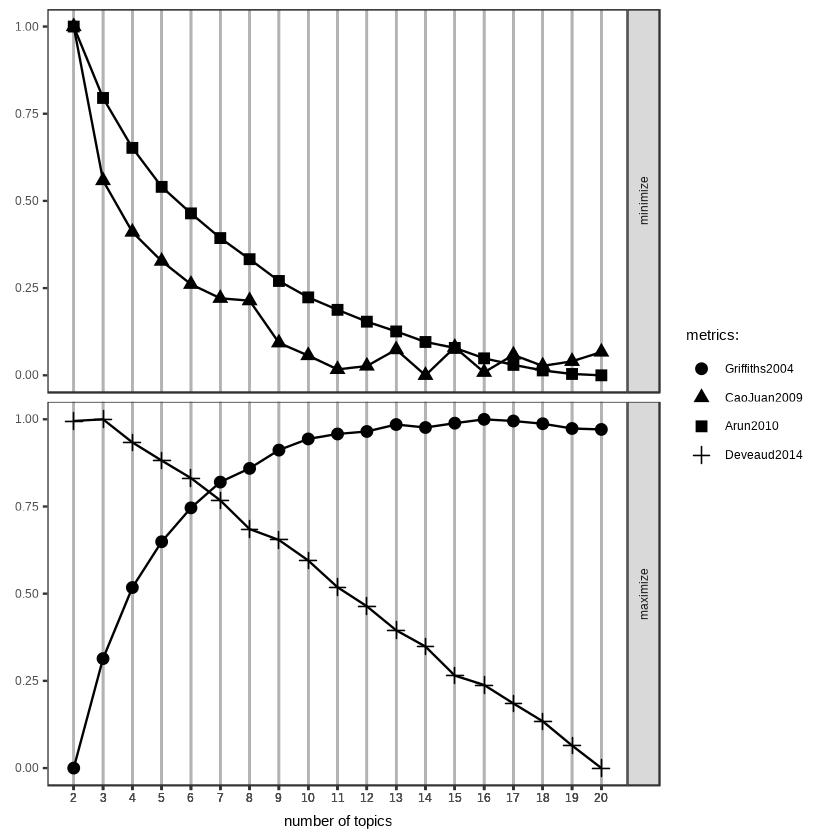

In [123]:
FindTopicsNumber_plot(models)

### Q7

In [124]:
lda_model <- models %>%
  filter (topics == 9) %>%
  pull(LDA_model) %>%
 .[[1]]

### Q8

In [125]:
term_topic <- tidy(lda_model, matrix = "beta")

In [126]:
top_term_topic <- term_topic %>%
  group_by(topic) %>%
  slice_max(beta, n = 10)

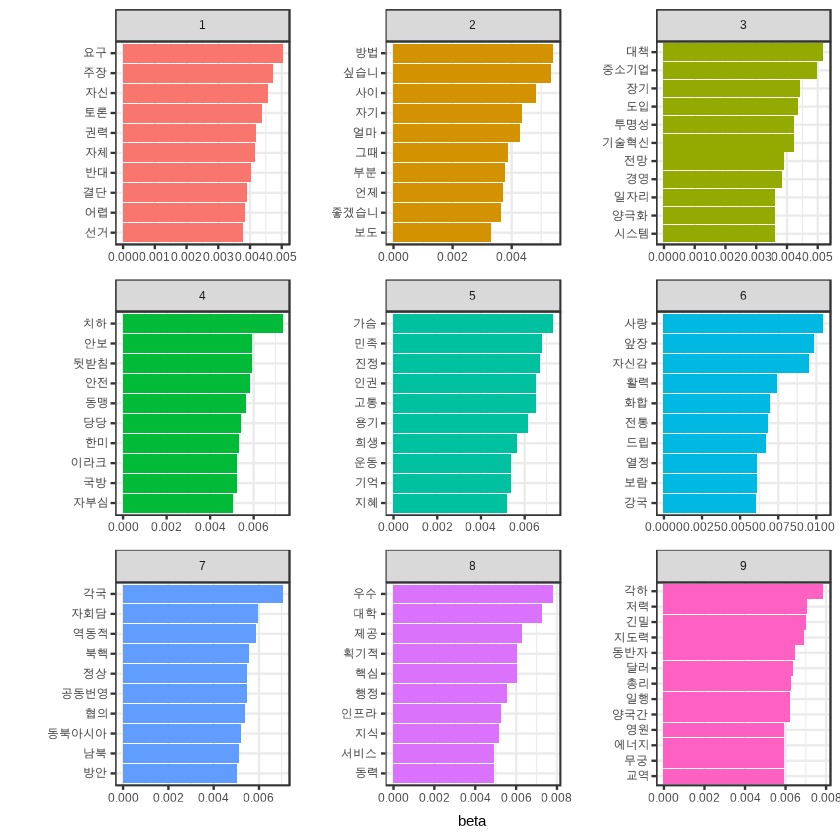

In [127]:
ggplot(top_term_topic,
       aes(x = reorder_within(term, beta, topic),
           y = beta,
           fill = factor(topic))) +
  geom_col(show.legend = F) +
  facet_wrap(~ topic, scales = "free", ncol = 3) +
  coord_flip () +
  scale_x_reordered() +
  labs(x = NULL)

### Q9

In [128]:
doc_topic <- tidy(lda_model, matrix = "gamma")

In [129]:
doc_class <- doc_topic %>%
  group_by(document) %>%
  slice_max(gamma, n = 1)

In [130]:
doc_class$document <- as.integer(doc_class$document)

In [131]:
speeches_topic <- speeches_raw %>%
  left_join(doc_class, by = c("id" = "document"))

In [132]:
speeches_topic %>% print

# A tibble: 813 x 11
   title  date  president place event source paragraph content    id topic gamma
   <chr>  <chr> <chr>     <chr> <chr> <chr>      <dbl> <chr>   <dbl> <int> <dbl>
 1 제16 ~ 2003~ 노무현    국내  취임~ 노무~          1 "주한~      1     7 0.157
 2 제16 ~ 2003~ 노무현    국내  취임~ 노무~          1 "존경~      2     5 0.232
 3 제16 ~ 2003~ 노무현    국내  기념~ 노무~          1 "존경~      3     7 0.236
 4 2·28~  2003~ 노무현    국내  기념~ 노무~          1 "43년 ~     4     5 0.287
 5 학군~  2003~ 노무현    국내  기념~ 노무~          1 "친애~      5     4 0.553
 6 제84~  2003~ 노무현    국내  기념~ 노무~          1 "존경~      6     5 0.399
 7 참여~  2003~ 노무현    국내  기타  노무~          1 "■ 인~      7     2 0.332
 8 육군~  2003~ 노무현    국내  기념~ 노무~          1 "친애~      8     4 0.589
 9 해군~  2003~ 노무현    국내  기념~ 노무~          1 "친애~      9     4 0.513
10 3·15~  2003~ 노무현    국내  기념~ 노무~          1 "존경~     10     5 0.227
# ... with 803 more rows


### Q10

In [133]:
speeches_topic %>%
  count(topic) %>% print

# A tibble: 9 x 2
  topic     n
  <int> <int>
1     1    67
2     2    44
3     3    62
4     4    71
5     5    84
6     6   134
7     7    84
8     8   119
9     9   148


### Q11

In [134]:
speeches_topic %>%
  filter(topic == 9) %>%
  arrange(-gamma) %>%
  select(content) %>% print

# A tibble: 148 x 1
   content                                                                      
   <chr>                                                                        
 1 안녕하십니까, 이처럼 따뜻하게 맞아주셔서 감사합니다. 나지모프 대외경제청장과~
 2 존경하는 룰라 대통령 각하 내외분, 그리고 귀빈 여러분, 오늘 저녁, BRICs 국가~ 
 3 존경하는 압델아지즈 부테플리카 알제리 대통령 각하, 그리고 내외 귀빈 여러분, ~
 4 존경하는 압둘 라흐만 알 라쉬드 상의연합회 회장, 압둘 라흐만 알 안카리 경협위~
 5 존경하는 바세스쿠 대통령 각하, 그리고 귀빈 여러분, 각하와 일행 여러분의 방한~
 6 존경하는 일함 알리예프 대통령 각하 내외분, 그리고 귀빈 여러분, 나와 우리 일~ 
 7 존경하는 키르츠네르 대통령 각하 내외분, 그리고 귀빈 여러분, 우리 내외와 일행~
 8 존경하는,카리모프, 대통령 각하 내외분, 그리고 귀빈 여러분, 각하 내외분과 일~ 
 9 2005년 5월 10일 존경하는 카리모프 대통령 각하 내외분, 그리고 귀빈 여러분, 우~
10 존경하는 빌토르 바비욱 루마니아 상공회의소 회장, 그리고 손경식 대한상의 회장~
# ... with 138 more rows
